In [34]:
import pandas as pd
import numpy  as np
import gc; gc.collect()

from   pathlib  import Path

import warnings
warnings.filterwarnings("ignore")

In [35]:
YFLOAD_PATH = '/Users/frkornet/CDA/Project/stockie/data/yfin/'
TRADE_PERIOD    = "10y"
NAME_MAP        = f'/Users/frkornet/CDA/Project/fund_indicators/name_map.csv'

In [36]:
def get_stock_n_smooth(ticker, period):
    """
    Copy of what is in util.py. Except this version reads what has been read 
    from yfinance and stored on file. The stored version is smoothed already, 
    and reading from disk should be much faster as it avoids the expensive 
    smoothing operation. The reading from file, will only return success if 
    there is at least 5 years worth of data to work with. 
    """
    gc.collect()
    try:
       hist = pd.read_csv(f'{YFLOAD_PATH}{ticker}.csv')
       hist.index = hist.Date.values
       del hist['Date']
       success = len(hist) > 5 * 252
       print(f'Successfully retrieved smoothed price data for {ticker} '+
             f'(len(hist)={len(hist)}, success={success})')
    except:
       hist = None
       success = False
       print(f'Failed to find {ticker}.csv in {YFLOAD_PATH}!')
    
    return success, hist

In [37]:
ticker = 'ABCB'
target = 'target'
success, hist = get_stock_n_smooth(ticker, TRADE_PERIOD)
assert success == True, "Unable to get historical price data and smooth price!"
hist[target] = 0
hist

Successfully retrieved smoothed price data for ABCB (len(hist)=2517, success=True)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratio,target
2011-02-14,9.17,9.38,9.16,9.31,18700,0.0,0,9.205647,NaN,0
2011-02-15,9.24,9.34,9.14,9.22,15700,0.0,0,9.203333,NaN,0
2011-02-16,9.23,9.31,9.15,9.17,13800,0.0,0,9.201019,NaN,0
2011-02-17,9.19,9.19,9.03,9.10,60800,0.0,0,9.198705,NaN,0
2011-02-18,9.19,9.26,9.14,9.24,48300,0.0,0,9.196392,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-08,44.38,45.14,43.70,45.08,293600,0.0,0,44.230497,13.660606,0
2021-02-09,45.00,45.73,44.38,45.51,551400,0.0,0,44.372137,13.790909,0
2021-02-10,45.70,46.98,45.30,46.09,424600,0.0,0,44.513778,13.966667,0
2021-02-11,46.05,46.58,44.68,45.66,317500,0.0,0,44.655419,13.836364,0


In [38]:
hist_orig = pd.read_csv('/Users/frkornet/CDA/Project/stockie/data/yfin_bak/ABCB.csv')
hist_orig.index = hist_orig.Date.values
del hist_orig['Date']
hist_orig

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
2011-02-14,9.17,9.38,9.16,9.31,18700,0.0,0,9.205647
2011-02-15,9.24,9.34,9.14,9.22,15700,0.0,0,9.203333
2011-02-16,9.23,9.31,9.15,9.17,13800,0.0,0,9.201019
2011-02-17,9.19,9.19,9.03,9.10,60800,0.0,0,9.198705
2011-02-18,9.19,9.26,9.14,9.24,48300,0.0,0,9.196392
...,...,...,...,...,...,...,...,...
2021-02-08,44.38,45.14,43.70,45.08,293600,0.0,0,44.230497
2021-02-09,45.00,45.73,44.38,45.51,551400,0.0,0,44.372137
2021-02-10,45.70,46.98,45.30,46.09,424600,0.0,0,44.513778
2021-02-11,46.05,46.58,44.68,45.66,317500,0.0,0,44.655419


In [39]:
def features(data, target):
    """ 
    Given a standard yfinance data dataframe, add features that will help
    the balanced scorecard to recognize buy and sell signals in the data.
    The features are added as columns in the data dataframe. 
    
    The original hist dataframe from yfinance is provided, so we can copy
    the target to the data dataframe. The data dataframe with the extra 
    features is returned. The target argument contains the name of the 
    column that contains the the target.
    """
    windows = [3, 5, 10, 15, 20, 30, 45, 60] 

    for i in windows:
        ma = data.Close.rolling(i).mean()
        # Moving Average Convergence Divergence (MACD)
        data[f'MACD_{i}']    = ma - data.Close
        data[f'PctDiff_{i}'] = data.Close.diff(i)
        data[f'StdDev_{i}']  = data.Close.rolling(i).std()


    exclude_cols = [target, 'smooth', 'Close', 'Date', 'Volume', 'Dividends', 'Stock Splits'] 
    factor = data.Close.copy()
    for c in data.columns.tolist():
        if c in exclude_cols:
           continue
        data[c] = data[c] / factor

    for i in windows:
        #data[f'RSI_{i}']     = RSI(data, i)
        #data[f'WPR_{i}']     = WPR(data, i)
        #data[f'MFI_{i}']     = MFI(data, i)
        data[f'BBP_{i}']      = BBP(data, i)
        
    data = data.dropna()
    
    return data

In [40]:
def RSI_Frank(df, window):
    price = hist['Close']
    rsi = price.copy()
    
    daily_rets = price.copy()
    daily_rets.values[1:] = price.values[1:] - price.values[:-1]
    daily_rets.values[0]  = np.nan

    up_rets = price.copy()
    up_rets[:] = np.nan
    up_rets[daily_rets >= 0] = daily_rets[daily_rets >= 0]
    up_rets = up_rets.fillna(0).cumsum()
    
    down_rets = price.copy()
    down_rets[:] = np.nan
    down_rets[daily_rets <  0] = -daily_rets[daily_rets <  0] # .fillna(0).cumsum() * -1.0
    down_rets = down_rets.fillna(0).cumsum() 
    
    up_gain = price.copy()
    up_gain[:window] = 0
    up_gain.values[window:] = up_rets.values[window:] - up_rets.values[:-window]

    down_loss = price.copy()
    down_loss.iloc[:window] = 0 
    down_loss.values[window:] = down_rets.values[window:] - down_rets.values[:-window]
    
    rs = (up_gain / window) / (down_loss / window)
    
    rsi = 100 - (100 / (1 + rs))
    rsi.iloc[:window] = np.nan

    rsi[rsi == np.inf] == 100 
    return rsi 

In [41]:
def RSI_Harshad(df, window):
    Gain=df['Close'].copy()
    Loss=df['Close'].copy()
    Avg_gain=df['Close'].copy()
    Avg_loss=df['Close'].copy()
    rsi=df['Close'].copy()

    Gain[:]=0.0
    Loss[:]=0.0
    Avg_gain[:]=0.0
    Avg_loss[:]=0.0
    rsi[:]=np.nan

    for i in range(1,len(df)):
        if df.Close.iloc[i] > df.Close.iloc[i-1]:
            Gain[i]=df.Close.iloc[i]-df.Close.iloc[i-1]
        else:
            # For loss save the absolute value on loss
            Loss[i]=abs(df.Close.iloc[i]-df.Close.iloc[i-1])
        if i>window:
            Avg_gain[i]=(Avg_gain[i-1]*(window-1)+Gain[i])/window
            Avg_loss[i]=(Avg_loss[i-1]*(window-1)+Loss[i])/window
            rsi[i]=(100*Avg_gain[i]/(Avg_gain[i]+Avg_loss[i])).round(2)

    return rsi

In [42]:
RSI_Frank(hist, 14)

2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    51.445864
2021-02-09    52.748691
2021-02-10    61.103253
2021-02-11    55.075758
2021-02-12    58.860265
Name: Close, Length: 2517, dtype: float64

In [43]:
RSI_Harshad(hist, 14)

2011-02-14      NaN
2011-02-15      NaN
2011-02-16      NaN
2011-02-17      NaN
2011-02-18      NaN
              ...  
2021-02-08    63.31
2021-02-09    64.55
2021-02-10    66.21
2021-02-11    63.83
2021-02-12    64.69
Name: Close, Length: 2517, dtype: float64

In [44]:
def RSI_indicator_v3(df, lookback):
    price = df.Close
    rsi = price.copy()

    daily_rets = price.copy()
    daily_rets.values[1:] = price.values[1:] - price.values[:-1]
    daily_rets.values[0]  = np.nan

    for day in range(df.shape[0]):
        up_gain = daily_rets.ix[day-lookback+1:day+1].where(daily_rets >= 0.0).sum()
        down_loss = -1 * daily_rets.ix[day-lookback+1:day+1].where(daily_rets < 0.0).sum()

        if down_loss == 0:
            rsi.ix[day] = 100 
        else:
            rs = (up_gain / lookback) / (down_loss / lookback)
            rsi.ix[day] = 100 - (100 / (1 + rs))

    return rsi

In [45]:
RSI_indicator_v3(hist, 14)

2011-02-14    100.000000
2011-02-15    100.000000
2011-02-16    100.000000
2011-02-17    100.000000
2011-02-18    100.000000
                 ...    
2021-02-08     51.445864
2021-02-09     52.748691
2021-02-10     61.103253
2021-02-11     55.075758
2021-02-12     58.860265
Name: Close, Length: 2517, dtype: float64

In [46]:
def RSI_indicator_v1(df, lookback):
    price = df.Close.copy()
    rsi = price.copy()

    for day in range(price.shape[0]):
        up_gain   = 0
        down_loss = 0

        for prev_day in range(day-lookback+1, day+1):
            delta = price.ix[prev_day] - price.ix[prev_day-1]

            if delta >= 0:
                up_gain = up_gain + delta
            else:
                down_loss = down_loss + (-1 * delta)

        if down_loss == 0:
            rsi.ix[day] = 100
        else:
            rs = (up_gain / lookback) / (down_loss / lookback)
            rsi.ix[day] = 100 - (100 / (1 + rs))

    # print(rsi)
    return rsi

In [47]:
RSI_indicator_v1(hist, 14)

2011-02-14    15.520790
2011-02-15    16.090482
2011-02-16    15.551266
2011-02-17    16.288475
2011-02-18    12.329412
                ...    
2021-02-08    51.445864
2021-02-09    52.748691
2021-02-10    61.103253
2021-02-11    55.075758
2021-02-12    58.860265
Name: Close, Length: 2517, dtype: float64

In [48]:
def RSI(df, window):
    delta = hist.Close.diff()

    up_days = delta.copy()
    up_days[delta<=0] = 0.0

    down_days = abs(delta.copy())
    down_days[delta>0]=0.0

    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()

    rsi = 100-100/(1+RS_up/RS_down)
    return rsi

In [49]:
RSI(hist, 14)

2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    51.445864
2021-02-09    52.748691
2021-02-10    61.103253
2021-02-11    55.075758
2021-02-12    58.860265
Name: Close, Length: 2517, dtype: float64

In [50]:
np.allclose(RSI_Frank(hist,14)[14:], RSI(hist,14)[14:])

True

In [51]:
def WPR(df, window):

    Highest_High = df['High'].rolling(window,min_periods=window).max()
    Lowest_Low   = df['Low'].rolling(window,min_periods=window).min()
    wpr=100 *(df['Close'] - Highest_High)/(Highest_High - Lowest_Low)

    return wpr

In [52]:
def MFI(df, window):

    typical_price = (df['High'] + df['Low'] + df['Close'])/3
    raw_money_flow = typical_price*df['Volume']

    idx = typical_price>typical_price.shift(1)

    pos_money_flow = raw_money_flow.copy()
    pos_money_flow.iloc[:] = 0.0
    pos_money_flow.loc[idx] = raw_money_flow.loc[idx]

    neg_money_flow = raw_money_flow.copy()
    neg_money_flow.iloc[:] = 0.0
    neg_money_flow.loc[~idx] = raw_money_flow.loc[~idx]

    mfi_pos = pos_money_flow.rolling(window).sum()
    mfi_neg = neg_money_flow.rolling(window).sum()
    mfi = 100 * mfi_pos / (mfi_pos+mfi_neg)

    return mfi

In [53]:
def BBP(df, window):   
    MA=df['Close'].rolling(window).mean()
    Std_Dev=df['Close'].rolling(window).std()

    BOLU=MA+2*Std_Dev
    BOLL=MA-2*Std_Dev

    return ( df['Close'] - BOLL) / (BOLU - BOLL)

In [54]:
BBP(hist,3)

2011-02-14         NaN
2011-02-15         NaN
2011-02-16    0.276826
2011-02-17    0.237324
2011-02-18    0.750000
                ...   
2021-02-08    0.787290
2021-02-09    0.707806
2021-02-10    0.761417
2021-02-11    0.422494
2021-02-12    0.542178
Name: Close, Length: 2517, dtype: float64

In [55]:
def get_pe(name, ticker):

    sub = pd.read_parquet(data_path / '2020_4' / 'parquet' / 'sub.parquet')
    corp = sub[sub.name == name].T.dropna().squeeze()

    # Get details on the forms
    corp_subs = pd.DataFrame()
    cik = corp.T.cik

    if type(cik) is int:
        cik_l = [ cik ]
    else:
        cik_l = list(corp.T.cik.unique())

    for sub in data_path.glob('**/sub.parquet'):
        sub = pd.read_parquet(sub)
        idx = (sub.cik.isin(cik_l)) & (sub.form.isin(['10-Q', '10-K']))
        corp_sub = sub.loc[idx]
        corp_subs = pd.concat([corp_subs, corp_sub])

    if len(corp_subs) == 0:
        print(f"No 10-Q or 10-K data found in SUB for {name} {ticker}!")
        return None
    
        # Get numeric details on the forms
    nums_file = data_path / 'PE_nums' / f'{ticker}_nums.parquet'
    if nums_file.exists():
        corp_nums = pd.read_parquet(nums_file)
    else:
        print("File not available, will process the individual num files instead")

        corp_nums = pd.DataFrame()
        for num in data_path.glob('**/num.parquet'):
            num = pd.read_parquet(num).drop('dimh', axis=1)
            corp_num = num[num.adsh.isin(corp_subs.adsh)]
            corp_nums = pd.concat([corp_nums, corp_num])

        assert len(corp_nums) != 0, "No rows in corp_nums!"
        corp_nums.ddate = pd.to_datetime(corp_nums.ddate, format='%Y%m%d')
        corp_nums.to_parquet(nums_file)

    # Retrieve the Earnings per share diluted
    # It only keeps the latest reported earnings.
    # Needs be refined over time as it is leaking information here.
    idx = (corp_nums.tag == 'EarningsPerShareDiluted') & (corp_nums.qtrs == 1)
    eps = corp_nums.loc[idx].drop('tag', axis=1)
    if len(eps) == 0:
        print("No quarterly reports with 'EarningsPerShareDiluted' available!")
        return None

    eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
    eps.index = eps.ddate.values
    eps = eps[['ddate', 'value']]
    eps = eps.sort_values(by='ddate', ascending=True)
    print(f'len(eps)={len(eps)}')

    # Get stock data and process splits and adjust reported earnings
    # corp_stock =yf.Ticker(ticker).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
    success, corp_stock = get_stock_n_smooth(ticker, TRADE_PERIOD)
    if success == False or len(corp_stock) == 0:
        print(f"Yfinance did not return any rows!")
        return None
    print(f'len(corp_stock)={len(corp_stock)}')
    
    splits = corp_stock[['Stock Splits']].loc[corp_stock['Stock Splits'] > 0]
    splits['Split_Date'] = splits.index

    for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
        split_date  = str(index)[:10]
        stock_split = row['Stock Splits']
        print(split_date, stock_split)
        eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

    eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
    eps = eps.rolling(window=4).sum()#.dropna()

    # Calculate p/e ratio
    pe = corp_stock.Close.to_frame('price').join(eps.to_frame('eps'))
    pe = pe.fillna(method='ffill')#.dropna()
    pe['P/E Ratio'] = pe.price.div(pe.eps)
    return pe


In [56]:
name_map = pd.read_csv(NAME_MAP)
name_map[name_map.ticker == 'AMRB']

,ticker,stocks_name,subs_name,data
47,AMRB,AMERICAN RIVER BANKSHARES,AMERICAN RIVER BANKSHARES,1


In [57]:
ticker = 'AMRB'
subs_name = 'AMERICAN RIVER BANKSHARES'
subs_name

'AMERICAN RIVER BANKSHARES'

In [58]:
data_path = Path('/Users')
data_path = data_path / 'frkornet' / 'CDA' / 'Project' / 'fund_indicators' / 'data'
data_path

PosixPath('/Users/frkornet/CDA/Project/fund_indicators/data')

In [59]:
data_path / '2020_4' / 'parquet' / 'sub.parquet'

PosixPath('/Users/frkornet/CDA/Project/fund_indicators/data/2020_4/parquet/sub.parquet')

In [60]:
pe_df = get_pe(subs_name, ticker)

len(eps)=29
Successfully retrieved smoothed price data for AMRB (len(hist)=2517, success=True)
len(corp_stock)=2517


In [61]:
len(pe_df)

2518

In [62]:
error_l = ['AMN', 'AMRB', 'ARAY', 'BLL', 'CFX', 'CGNX', 'CRI', 'CTRN', 'CXDC', 
           'GFF', 'GHM', 'GORO', 'HBI', 'HSC', 'INCY', 'IPHI', 'JOE', 'L', 'MBI', 
           'MRC', 'QCRH', 'RGR', 'TACT', 'TRC', 'TSBK', 'T', 'UFCS', 'ULBI', 'VNDA', 'ZIXI']
for t in error_l:
    subs_name = str(name_map['subs_name'].loc[name_map.ticker == t].unique()[0])
    print(t, subs_name)
    pe_df = get_pe(subs_name, t)
    pe_df['date'] = pe_df.index
    display(pe_df.loc[pe_df.loc[pe_df.date.duplicated()].date])
    print('')

AMN AMN HEALTHCARE SERVICES INC
len(eps)=37
Successfully retrieved smoothed price data for AMN (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2012-12-31,11.55,0.36,32.083333,2012-12-31
2012-12-31,11.55,0.42,27.500000,2012-12-31



AMRB AMERICAN RIVER BANKSHARES
len(eps)=29
Successfully retrieved smoothed price data for AMRB (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2015-09-30,8.93,0.64,13.953125,2015-09-30
2015-09-30,8.93,0.70,12.757143,2015-09-30



ARAY ACCURAY INC
len(eps)=11
Successfully retrieved smoothed price data for ARAY (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2016-06-30,5.19,-0.57,-9.105263,2016-06-30
2016-06-30,5.19,-0.45,-11.533333,2016-06-30



BLL BALL CORP
len(eps)=41
Successfully retrieved smoothed price data for BLL (len(hist)=2517, success=True)
len(corp_stock)=2517
2017-05-17 2.0
2011-02-16 2.0


,price,eps,P/E Ratio,date
2015-09-30,29.45,1.07,27.523364,2015-09-30
2015-09-30,29.45,0.96,30.677083,2015-09-30



CFX COLFAX CORP
len(eps)=25
Successfully retrieved smoothed price data for CFX (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2015-12-31,23.35,1.57,14.872611,2015-12-31
2015-12-31,23.35,1.29,18.100775,2015-12-31



CGNX COGNEX CORP
len(eps)=34
Successfully retrieved smoothed price data for CGNX (len(hist)=2517, success=True)
len(corp_stock)=2517
2017-12-04 2.0
2013-09-17 2.0


,price,eps,P/E Ratio,date
2018-12-31,37.33,1.24,30.104839,2018-12-31
2018-12-31,37.33,1.49,25.053691,2018-12-31



CRI CARTERS INC
len(eps)=41
Successfully retrieved smoothed price data for CRI (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2014-12-31,80.23,3.63,22.101928,2014-12-31
2014-12-31,80.23,4.29,18.701632,2014-12-31



CTRN CITI TRENDS INC
len(eps)=37
Successfully retrieved smoothed price data for CTRN (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2017-10-31,20.94,0.91,23.010989,2017-10-31
2017-10-31,20.94,1.02,20.529412,2017-10-31



CXDC CHINA XD PLASTICS CO LTD
len(eps)=13
Successfully retrieved smoothed price data for CXDC (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2014-12-31,5.43,1.88,2.888298,2014-12-31
2014-12-31,5.43,2.02,2.688119,2014-12-31



GFF GRIFFON CORP
len(eps)=33
Successfully retrieved smoothed price data for GFF (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2016-09-30,15.04,0.23,65.391304,2016-09-30
2016-09-30,15.04,0.22,68.363636,2016-09-30



GHM GRAHAM CORP
len(eps)=37
Successfully retrieved smoothed price data for GHM (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2016-09-30,17.33,0.32,54.156250,2016-09-30
2016-09-30,17.33,0.32,54.156250,2016-09-30
2018-12-31,21.54,0.53,40.641509,2018-12-31
2018-12-31,21.54,0.45,47.866667,2018-12-31



GORO GOLD RESOURCE CORP
len(eps)=30
Successfully retrieved smoothed price data for GORO (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2018-12-31,3.9227,0.15,26.151333,2018-12-31
2018-12-31,3.9227,0.07,56.038571,2018-12-31



HBI HANESBRANDS INC.
len(eps)=39
Successfully retrieved smoothed price data for HBI (len(hist)=2517, success=True)
len(corp_stock)=2517
2015-03-04 4.0


,price,eps,P/E Ratio,date
2015-12-31,24.74,1.06,23.339623,2015-12-31
2015-12-31,24.74,1.23,20.113821,2015-12-31



HSC HARSCO CORP
len(eps)=32
Successfully retrieved smoothed price data for HSC (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2011-06-30,26.76,1.23,21.756098,2011-06-30
2011-06-30,26.76,1.33,20.120301,2011-06-30



INCY INCYTE CORP
len(eps)=30
Successfully retrieved smoothed price data for INCY (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2012-12-31,16.61,-0.45,-36.911111,2012-12-31
2012-12-31,16.61,-0.10,-166.100000,2012-12-31



IPHI INPHI CORP
len(eps)=37
Successfully retrieved smoothed price data for IPHI (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2014-06-30,14.68,-0.08,-183.500000,2014-06-30
2014-06-30,14.68,0.09,163.111111,2014-06-30



JOE ST JOE CO
len(eps)=9
Successfully retrieved smoothed price data for JOE (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2011-06-30,20.76,-0.22,-94.363636,2011-06-30
2011-06-30,20.76,-0.27,-76.888889,2011-06-30



L LOEWS CORP
len(eps)=28
Successfully retrieved smoothed price data for L (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2012-12-31,38.82,1.43,27.146853,2012-12-31
2012-12-31,38.82,0.43,90.279070,2012-12-31
2014-12-31,40.54,2.52,16.087302,2014-12-31
2014-12-31,40.54,2.38,17.033613,2014-12-31



MBI MBIA INC
len(eps)=34
Successfully retrieved smoothed price data for MBI (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2013-09-30,10.23,0.63,16.238095,2013-09-30
2013-09-30,10.23,1.26,8.119048,2013-09-30
2019-09-30,9.23,-1.86,-4.962366,2019-09-30
2019-09-30,9.23,-0.50,-18.460000,2019-09-30



MRC MRC GLOBAL INC.
len(eps)=37
Successfully retrieved smoothed price data for MRC (len(hist)=2225, success=True)
len(corp_stock)=2225


,price,eps,P/E Ratio,date
2016-06-30,14.21,-4.20,-3.383333,2016-06-30
2016-06-30,14.21,-4.54,-3.129956,2016-06-30



QCRH QCR HOLDINGS INC
len(eps)=36
Successfully retrieved smoothed price data for QCRH (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2011-09-30,8.3,NaN,NaN,2011-09-30
2011-09-30,8.3,NaN,NaN,2011-09-30



RGR STURM RUGER & CO INC
len(eps)=37
Successfully retrieved smoothed price data for RGR (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2011-06-30,16.19,NaN,NaN,2011-06-30
2011-06-30,16.19,NaN,NaN,2011-06-30



TACT TRANSACT TECHNOLOGIES INC
len(eps)=36
Successfully retrieved smoothed price data for TACT (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2015-12-31,7.43,0.40,18.575000,2015-12-31
2015-12-31,7.43,0.56,13.267857,2015-12-31



TRC TEJON RANCH CO
len(eps)=37
Successfully retrieved smoothed price data for TRC (len(hist)=2517, success=True)
len(corp_stock)=2517
2017-10-02 1.03
2013-08-29 1.031


,price,eps,P/E Ratio,date
2013-12-31,35.69,0.190380,187.467387,2013-12-31
2013-12-31,35.69,0.249508,143.041522,2013-12-31



TSBK TIMBERLAND BANCORP INC
len(eps)=36
Successfully retrieved smoothed price data for TSBK (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2013-09-30,7.5,0.58,12.931034,2013-09-30
2013-09-30,7.5,0.60,12.500000,2013-09-30



T AT&T INC.
len(eps)=42
Successfully retrieved smoothed price data for T (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2014-06-30,24.12,3.41,7.073314,2014-06-30
2014-06-30,24.12,3.37,7.157270,2014-06-30



UFCS UNITED FIRE GROUP INC
len(eps)=34
Successfully retrieved smoothed price data for UFCS (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2012-12-31,16.63,0.55,30.236364,2012-12-31
2012-12-31,16.63,0.64,25.984375,2012-12-31



ULBI ULTRALIFE CORP
len(eps)=28
Successfully retrieved smoothed price data for ULBI (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2013-09-30,4.0,-0.04,-100.0,2013-09-30
2013-09-30,4.0,-0.02,-200.0,2013-09-30



VNDA VANDA PHARMACEUTICALS INC.
len(eps)=23
Successfully retrieved smoothed price data for VNDA (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2014-12-31,14.32,1.26,11.365079,2014-12-31
2014-12-31,14.32,3.14,4.560510,2014-12-31



ZIXI ZIX CORP
len(eps)=37
Successfully retrieved smoothed price data for ZIXI (len(hist)=2517, success=True)
len(corp_stock)=2517


,price,eps,P/E Ratio,date
2016-03-31,3.93,0.09,43.666667,2016-03-31
2016-03-31,3.93,0.10,39.300000,2016-03-31


In [63]:
pe_df = get_pe(subs_name, ticker)
pe_df['Date'] = pe_df.index
pe_df = pe_df.groupby(by='Date').max().reset_index()
pe_df

len(eps)=29
Successfully retrieved smoothed price data for AMRB (len(hist)=2517, success=True)
len(corp_stock)=2517


,Date,price,eps,P/E Ratio
0,2011-02-14,5.81,NaN,NaN
1,2011-02-15,6.02,NaN,NaN
2,2011-02-16,6.08,NaN,NaN
3,2011-02-17,5.86,NaN,NaN
4,2011-02-18,5.75,NaN,NaN
...,...,...,...,...
2512,2021-02-08,13.84,1.11,12.468468
2513,2021-02-09,13.46,1.11,12.126126
2514,2021-02-10,13.63,1.11,12.279279
2515,2021-02-11,14.13,1.11,12.729730


In [64]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratio,target
2011-02-14,9.17,9.38,9.16,9.31,18700,0.0,0,9.205647,NaN,0
2011-02-15,9.24,9.34,9.14,9.22,15700,0.0,0,9.203333,NaN,0
2011-02-16,9.23,9.31,9.15,9.17,13800,0.0,0,9.201019,NaN,0
2011-02-17,9.19,9.19,9.03,9.10,60800,0.0,0,9.198705,NaN,0
2011-02-18,9.19,9.26,9.14,9.24,48300,0.0,0,9.196392,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-08,44.38,45.14,43.70,45.08,293600,0.0,0,44.230497,13.660606,0
2021-02-09,45.00,45.73,44.38,45.51,551400,0.0,0,44.372137,13.790909,0
2021-02-10,45.70,46.98,45.30,46.09,424600,0.0,0,44.513778,13.966667,0
2021-02-11,46.05,46.58,44.68,45.66,317500,0.0,0,44.655419,13.836364,0


In [65]:
hist.join(pe_df['P/E Ratio'], lsuffix='l_', rsuffix='r_')

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratiol_,target,P/E Ratior_
2011-02-14,9.17,9.38,9.16,9.31,18700,0.0,0,9.205647,NaN,0,NaN
2011-02-15,9.24,9.34,9.14,9.22,15700,0.0,0,9.203333,NaN,0,NaN
2011-02-16,9.23,9.31,9.15,9.17,13800,0.0,0,9.201019,NaN,0,NaN
2011-02-17,9.19,9.19,9.03,9.10,60800,0.0,0,9.198705,NaN,0,NaN
2011-02-18,9.19,9.26,9.14,9.24,48300,0.0,0,9.196392,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,44.38,45.14,43.70,45.08,293600,0.0,0,44.230497,13.660606,0,NaN
2021-02-09,45.00,45.73,44.38,45.51,551400,0.0,0,44.372137,13.790909,0,NaN
2021-02-10,45.70,46.98,45.30,46.09,424600,0.0,0,44.513778,13.966667,0,NaN
2021-02-11,46.05,46.58,44.68,45.66,317500,0.0,0,44.655419,13.836364,0,NaN


In [71]:
pe_df.loc[pe_df['P/E Ratio'].isnull()]

,Date,price,eps,P/E Ratio,date
0,2011-02-14,5.81,NaN,NaN,0
1,2011-02-15,6.02,NaN,NaN,1
2,2011-02-16,6.08,NaN,NaN,2
3,2011-02-17,5.86,NaN,NaN,3
4,2011-02-18,5.75,NaN,NaN,4
...,...,...,...,...,...
655,2013-09-23,8.04,NaN,NaN,655
656,2013-09-24,8.17,NaN,NaN,656
657,2013-09-25,7.97,NaN,NaN,657
658,2013-09-26,8.05,NaN,NaN,658


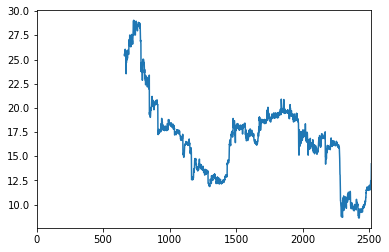

In [75]:
pe_df['P/E Ratio'].plot()

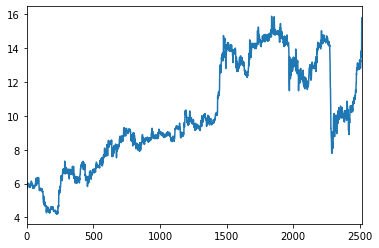

In [76]:
pe_df['price'].plot()

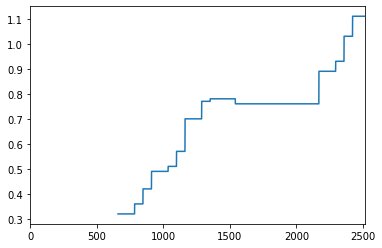

In [77]:
pe_df['eps'].plot()

In [78]:
ticker = 'AAPL'
target = 'target'
success, hist = get_stock_n_smooth(ticker, TRADE_PERIOD)
assert success == True, "Unable to get historical price data and smooth price!"
hist[target] = 0
hist

Successfully retrieved smoothed price data for AAPL (len(hist)=2517, success=True)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratio,target
2011-02-14,10.98,11.06,10.97,11.05,310416400,0.0,0.0,10.952331,NaN,0
2011-02-15,11.05,11.07,11.00,11.07,284174800,0.0,0.0,10.937638,NaN,0
2011-02-16,11.10,11.23,11.09,11.17,481157600,0.0,0.0,10.922946,NaN,0
2011-02-17,10.99,11.08,10.97,11.02,530583200,0.0,0.0,10.908253,NaN,0
2011-02-18,11.03,11.06,10.75,10.78,816057200,0.0,0.0,10.893560,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-08,136.03,136.96,134.92,136.91,71297200,0.0,0.0,136.688054,41.996933,0
2021-02-09,136.62,137.88,135.85,136.01,76774200,0.0,0.0,136.930016,41.720859,0
2021-02-10,136.48,136.99,134.40,135.39,73046600,0.0,0.0,137.171978,41.530675,0
2021-02-11,135.90,136.39,133.77,135.13,64154400,0.0,0.0,137.413940,41.450920,0


In [79]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratio,target
2011-02-14,10.98,11.06,10.97,11.05,310416400,0.0,0.0,10.952331,NaN,0
2011-02-15,11.05,11.07,11.00,11.07,284174800,0.0,0.0,10.937638,NaN,0
2011-02-16,11.10,11.23,11.09,11.17,481157600,0.0,0.0,10.922946,NaN,0
2011-02-17,10.99,11.08,10.97,11.02,530583200,0.0,0.0,10.908253,NaN,0
2011-02-18,11.03,11.06,10.75,10.78,816057200,0.0,0.0,10.893560,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-08,136.03,136.96,134.92,136.91,71297200,0.0,0.0,136.688054,41.996933,0
2021-02-09,136.62,137.88,135.85,136.01,76774200,0.0,0.0,136.930016,41.720859,0
2021-02-10,136.48,136.99,134.40,135.39,73046600,0.0,0.0,137.171978,41.530675,0
2021-02-11,135.90,136.39,133.77,135.13,64154400,0.0,0.0,137.413940,41.450920,0


In [82]:
ticker = 'AAPL'
target = 'target'
success, hist = get_stock_n_smooth(ticker, TRADE_PERIOD)
assert success == True, "Unable to get historical price data and smooth price!"
hist[target] = 0
sum(BBP(hist,14) == np.inf)

Successfully retrieved smoothed price data for AAPL (len(hist)=2517, success=True)


0

In [83]:
#hist = features(hist, target)

In [86]:
hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'smooth', 'P/E Ratio', 'target'],
      dtype='object')

In [85]:
len(hist)

2517

In [87]:
Gain=hist['Close'].copy()
Loss=hist['Close'].copy()
Avg_gain=hist['Close'].copy()
Avg_loss=hist['Close'].copy()
rsi=hist['Close'].copy()

Gain[:]=0.0
Loss[:]=0.0
Avg_gain[:]=0.0
Avg_loss[:]=0.0
rsi[:]=np.nan

In [88]:
change = hist.Close - hist.Close.shift(1)
change = change.fillna(0)
change

2011-02-14    0.00
2011-02-15    0.02
2011-02-16    0.10
2011-02-17   -0.15
2011-02-18   -0.24
              ... 
2021-02-08    0.15
2021-02-09   -0.90
2021-02-10   -0.62
2021-02-11   -0.26
2021-02-12    0.24
Name: Close, Length: 2517, dtype: float64

In [89]:
gain = change.copy()
gain [ gain <= 0] = 0
gain

2011-02-14    0.00
2011-02-15    0.02
2011-02-16    0.10
2011-02-17    0.00
2011-02-18    0.00
              ... 
2021-02-08    0.15
2021-02-09    0.00
2021-02-10    0.00
2021-02-11    0.00
2021-02-12    0.24
Name: Close, Length: 2517, dtype: float64

In [90]:
loss = change.copy()
loss [ loss > 0] = 0
loss = np.abs(loss)
loss

2011-02-14    0.00
2011-02-15    0.00
2011-02-16    0.00
2011-02-17    0.15
2011-02-18    0.24
              ... 
2021-02-08    0.00
2021-02-09    0.90
2021-02-10    0.62
2021-02-11    0.26
2021-02-12    0.00
Name: Close, Length: 2517, dtype: float64

In [91]:
window = 14
Avg_gain[:] = 0.0
Avg_loss[:] = 0.0
for i in range(1,len(hist)):
    if hist.Close.iloc[i] > hist.Close.iloc[i-1]:
        Gain[i]=hist.Close.iloc[i]-hist.Close.iloc[i-1]
    else:
        # For loss save the absolute value on loss
        Loss[i]=abs(hist.Close.iloc[i]-hist.Close.iloc[i-1])
    if i>=window:
        Avg_gain[i]=(Avg_gain[i-1]*(window-1)+Gain[i]) / window
        Avg_loss[i]=(Avg_loss[i-1]*(window-1)+Loss[i]) / window
#         Avg_gain[i] = np.sum(Gain[i-window+1:i+1]) / window
#         Avg_loss[i] = np.sum(Loss[i-window+1:i+1]) / window
        rsi[i]=(100*Avg_gain[i]/(Avg_gain[i]+Avg_loss[i]))

In [92]:
np.all(Gain == gain)

True

In [93]:
np.all(Loss == loss)

True

In [94]:
Avg_gain [ Avg_gain > 0]

2011-03-08    0.000714
2011-03-09    0.000663
2011-03-10    0.000616
2011-03-11    0.012715
2011-03-14    0.015378
                ...   
2021-02-08    1.178553
2021-02-09    1.094371
2021-02-10    1.016201
2021-02-11    0.943616
2021-02-12    0.893357
Name: Close, Length: 2502, dtype: float64

In [95]:
Avg_gain[15:16]

2011-03-08    0.000714
Name: Close, dtype: float64

In [96]:
gain.fillna(0).rolling(14).mean()[14:]

2011-03-07    0.063571
2011-03-08    0.062857
2011-03-09    0.055714
2011-03-10    0.055714
2011-03-11    0.067857
                ...   
2021-02-08    1.566429
2021-02-09    1.267143
2021-02-10    0.921429
2021-02-11    0.765000
2021-02-12    0.507143
Name: Close, Length: 2503, dtype: float64

In [97]:
def RSI_Harshad_fixed(df, window):
    rsi=df['Close'].copy()
    rsi[:]=np.nan

    change = df.Close - df.Close.shift(1)
    change = change.fillna(0)

    gain = change.copy()
    gain [ gain <= 0] = 0
    
    loss = change.copy()
    loss [ loss > 0] = 0
    loss = np.abs(loss)
    
    Avg_gain = gain.fillna(0).rolling(14).mean()
    Avg_loss = loss.fillna(0).rolling(14).mean()
    rsi = 100 * (Avg_gain / (Avg_gain + Avg_loss))

    return rsi

In [98]:
RSI_Harshad_fixed(hist, 14)

2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    63.399827
2021-02-09    56.677316
2021-02-10    47.636632
2021-02-11    42.584493
2021-02-12    32.961931
Name: Close, Length: 2517, dtype: float64

In [99]:
RSI_Frank(hist, 14)

2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    63.399827
2021-02-09    56.677316
2021-02-10    47.636632
2021-02-11    42.584493
2021-02-12    32.961931
Name: Close, Length: 2517, dtype: float64

In [100]:
np.allclose(RSI_Harshad_fixed(hist, 14)[14:], RSI_Frank(hist, 14)[14:])

True

In [101]:
%time RSI_Harshad_fixed(hist, 14)

CPU times: user 7.32 ms, sys: 584 µs, total: 7.9 ms
Wall time: 7.4 ms


2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    63.399827
2021-02-09    56.677316
2021-02-10    47.636632
2021-02-11    42.584493
2021-02-12    32.961931
Name: Close, Length: 2517, dtype: float64

In [102]:
%time RSI_Frank(hist, 14)

CPU times: user 12.5 ms, sys: 1.36 ms, total: 13.9 ms
Wall time: 12.6 ms


2011-02-14          NaN
2011-02-15          NaN
2011-02-16          NaN
2011-02-17          NaN
2011-02-18          NaN
                ...    
2021-02-08    63.399827
2021-02-09    56.677316
2021-02-10    47.636632
2021-02-11    42.584493
2021-02-12    32.961931
Name: Close, Length: 2517, dtype: float64

In [103]:
def RSI_v1(df, window):
    rsi=df['Close'].copy()
    rsi[:]=np.nan

    change = df.Close - df.Close.shift(1)
    change = change.fillna(0)

    gain = change.copy()
    gain [ gain <= 0] = 0

    loss = change.copy()
    loss [ loss > 0] = 0
    loss = np.abs(loss)

    avg_gain = gain[:window].mean()
    avg_loss = loss[:window].mean()

    i=window
    for g, l in zip(gain[window:], loss[window:]):
        avg_gain = (avg_gain * (window-1) + g) / window
        avg_loss = (avg_loss * (window-1) + l) / window
        rsi[i] = 100 * (avg_gain / (avg_gain + avg_loss) )
        i+=1

    return rsi

In [104]:
%%time 
for i in range(1000): rsi=RSI_v1(hist, 14)

CPU times: user 26.4 s, sys: 15.4 ms, total: 26.4 s
Wall time: 26.4 s


In [105]:
%%time 
for i in range(1000): rsi=RSI_Harshad(hist, 14)

CPU times: user 6min 18s, sys: 228 ms, total: 6min 18s
Wall time: 6min 19s


In [115]:
RSI_v1(hist, 14)[14:]

2011-03-07    46.578100
2011-03-08    46.900394
2011-03-09    44.039139
2011-03-10    39.381848
2011-03-11    45.268801
                ...    
2021-02-08    56.078438
2021-02-09    54.290032
2021-02-10    53.035249
2021-02-11    52.487389
2021-02-12    52.970336
Name: Close, Length: 2503, dtype: float64

In [116]:
RSI_Harshad(hist, 14)[14:]

2011-03-07       NaN
2011-03-08    100.00
2011-03-09      8.50
2011-03-10      3.06
2011-03-11     41.27
               ...  
2021-02-08     56.08
2021-02-09     54.29
2021-02-10     53.04
2021-02-11     52.49
2021-02-12     52.97
Name: Close, Length: 2503, dtype: float64

In [114]:
np.allclose(RSI_v1(hist, 14)[-5:], RSI_Harshad(hist, 14)[-5:])

False